# **Imports**

In [1]:
import json
import osmnx as ox
from collections import deque
import requests
import geocoder

# **Node Definition**

In [2]:
class Node:
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.state = state  
        self.parent = parent  
        self.action = action  
        self.path_cost = path_cost  

    def __str__(self):
        return f"# City: {self.state}, Distance crossed: {round(self.path_cost, 2)}KM"

# **Data Loading**

In [3]:
def load_data(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

data_file_path = "data/AlgiersHospitals.json"
algiers_hospitals = load_data(data_file_path)

data_file_path = "data/MapNodes.json"
nodes=load_data(data_file_path)

data_file_path = "data/MapEdges.json"
edges=load_data(data_file_path)
edges = {eval(key): value for key, value in edges.items()} # Turns keys from string into tuples

graph = ox.load_graphml(filepath="data/Map.graphml")

# **Problem Definition**

In [4]:
class problem:
    def __init__(self, initial_state, goal_state={"type":"public", "department":"General Surgery"}, transition_model=nodes, costs=edges, hospital_info=algiers_hospitals):
        self.initial_state = initial_state
        self.goal_state = goal_state
        self.transition_model = transition_model
        self.hospital_info = hospital_info
        self.costs=costs

    def actions(self, state):
        neighbour_nodes = self.transition_model[str(state)]["neighbors"]
        return neighbour_nodes
    
    #FIXME: Remove this function

    def result(self, state, action):
        return action

    def goal_test(self, state):
        hospital = nodes[str(state)]["hospital"]
        if hospital:
            if (
                self.goal_state["type"]==self.hospital_info[hospital]["type"] 
                and self.goal_state["department"] in self.hospital_info[hospital]["departments"]
            ):
                return True
        return False

    def step_cost(self, state, action):
        return self.costs[(state, action)]["length"]

    def child_node(self, parent, action):
        state = self.result(parent.state, action)
        path_cost = parent.path_cost + self.step_cost(parent.state, action)
        return Node(state=state, parent=parent, action=action, path_cost=path_cost)

# **Solver**

In [5]:
class Solver:
    def __init__(self, problem):
        self.problem = problem

    def breadth_first_search(self):
        initial_node = Node(state=self.problem.initial_state, path_cost=0)
        if self.problem.goal_test(initial_node.state):
            return self.solution(initial_node)

        frontier = deque([initial_node])
        explored = set()

        while frontier:
            node = frontier.popleft()
            explored.add(node.state)

            for action in self.problem.actions(node.state):
                child = self.problem.child_node(node, action)
                if child.state not in explored and child not in frontier:
                    if self.problem.goal_test(child.state):
                        return self.solution(child)
                    frontier.append(child)

        return "GOAL IS UNREACHABLE!"

    def solution(self, node):
        path = []
        while node:
            path.insert(0, node)
            node = node.parent
        return path

# **Utils**

In [6]:
def get_current_ip():
    try:
        response = requests.get('https://api.ipify.org')
        if response.status_code == 200:
            return response.text
        else:
            return None
    except requests.RequestException:
        return None

def get_current_location_coordinates():
    # Get current IP address
    current_ip = get_current_ip()
    if current_ip:
        try:
            # Get current location using IP address
            g = geocoder.ip(current_ip)
            # Extract latitude and longitude
            latitude, longitude = g.latlng
            return latitude, longitude
        except:
            return None
    else:
        return None

# **Main**

In [7]:
Y, X = get_current_location_coordinates()
initial_state=ox.distance.nearest_nodes(graph, X, Y, return_dist=False)
problem=problem(initial_state)
solver = Solver(problem)
solution_path = solver.breadth_first_search()

# **Visualisation**

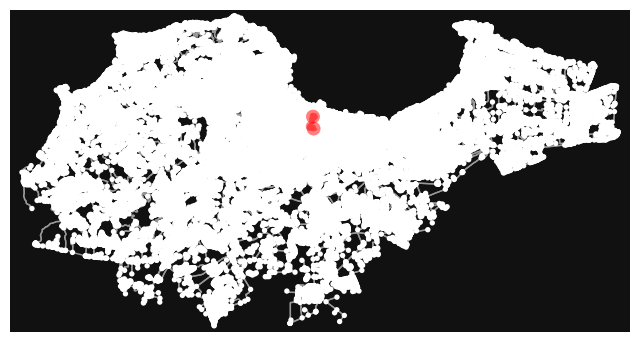

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
states=[]
for i in solution_path:
    states.append(i.state)


ox.plot.plot_graph_route(graph, states)